<a href="https://colab.research.google.com/github/ravillaleite/CVQKD-Reconciliation/blob/main/Construcao_PEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PEG algorithm implemented in https://github.com/Lcrypto/classic-PEG-

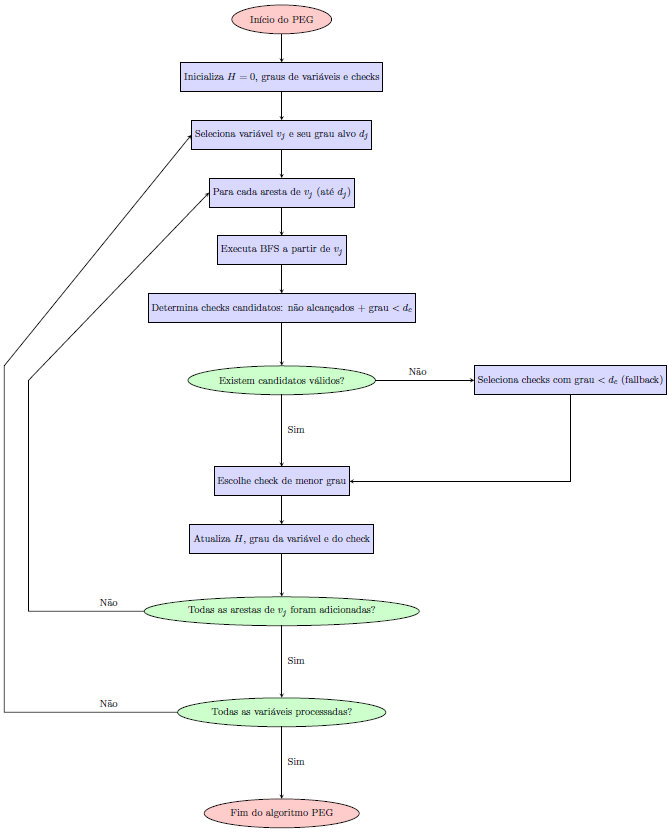

In [ ]:
import numpy as np
import copy

def find_smallest(array):
    """
    Retorna o índice do menor elemento em 'array'.
    Se houver empate, retorna o primeiro (menor índice).
    """
    if len(array) == 1:
        return 0
    elif len(array) == 2:
        return 0 if array[0] <= array[1] else 1
    else:
        mid = len(array) // 2  # >>> corrigido para Python 3
        arrayA = array[:mid]
        arrayB = array[mid:]
        smallA = find_smallest(arrayA)
        smallB = find_smallest(arrayB)
        if arrayA[smallA] <= arrayB[smallB]:
            return smallA
        else:
            return mid + smallB


class PEG:
    """
    Implementação do Progressive Edge Growth (PEG)
    para construção de matrizes LDPC.
    """

    def __init__(self, nvar, nchk, degree_sequence, verbose=False):
        self.degree_sequence = degree_sequence
        self.nvar = nvar
        self.nchk = nchk
        self.verbose = verbose

        # matriz H (nchk x nvar)
        self.H = np.zeros((nchk, nvar), dtype=np.int32)

        # graus atuais
        self.sym_degrees = np.zeros(nvar, dtype=np.int32)
        self.chk_degrees = np.zeros(nchk, dtype=np.int32)

        # representações de adjacência (redundantes, só para depuração)
        self.I_edge_chk2var = [[0 for _ in range(nvar)] for _ in range(nchk)]
        self.I_edge_var2chk = [[0 for _ in range(nchk)] for _ in range(nvar)]

    def grow_edge(self, var, chk):
        """Cria aresta var→chk"""
        self.I_edge_chk2var[chk][var] = 1
        self.I_edge_var2chk[var][chk] = 1
        self.H[chk, var] = 1
        self.sym_degrees[var] += 1
        self.chk_degrees[chk] += 1
        if self.verbose:
            print(f"  -> Aresta adicionada: var {var} → chk {chk}")

    def bfs(self, var):
        """
        BFS a partir da variável 'var'.
        Retorna o verificador escolhido para nova conexão.
        """
        if self.verbose:
            print(f"    Iniciando BFS a partir de var {var}")

        var_list = np.zeros(self.nvar, dtype=np.int32)
        var_list[var] = 1

        cur_chk_list = [0]*self.nchk
        new_chk_list = [0]*self.nchk
        chk_Q = []
        var_Q = [var]

        while True:
            # Expansão: var → checks
            for _vars in var_Q:
                for i in range(self.nchk):
                    if self.H[i, _vars] == 1:
                        if cur_chk_list[i] == 0:
                            new_chk_list[i] = 1
                            chk_Q.append(i)

            # Expansão: checks → vars
            var_Q = []
            for _chks in chk_Q:
                for j in range(self.nvar):
                    if self.H[_chks, j] == 1:
                        if var_list[j] == 0:
                            var_list[j] = 1
                            var_Q.append(j)
            chk_Q = []

            if self.verbose:
                print("    Visitados (checks):", new_chk_list)

            # critério de parada
            if new_chk_list.count(1) == self.nchk:
                if self.verbose:
                    print("    Todos os checks alcançados.")
                return self.find_smallest_chk(cur_chk_list)
            elif np.array_equal(new_chk_list, cur_chk_list):
                if self.verbose:
                    print("    BFS saturou (não cresce mais).")
                return self.find_smallest_chk(cur_chk_list)
            else:
                cur_chk_list = copy.copy(new_chk_list)

    def find_smallest_chk(self, cur_chk_list):
        """Escolhe o verificador com menor grau entre os não visitados"""
        index = []
        degree = []
        for i in range(len(cur_chk_list)):
            if cur_chk_list[i] == 0:
                index.append(i)
                degree.append(self.chk_degrees[i])
        chosen = index[find_smallest(degree)]
        if self.verbose:
            print(f"    Escolhido chk {chosen} (graus: {degree})")
        return chosen

    def progressive_edge_growth(self):
        """
        Executa o algoritmo PEG: conecta cada variável
        a verificadores de acordo com degree_sequence.
        """
        for var in range(self.nvar):
            print(f"\n[PEG] Crescendo arestas para var {var}")
            for k in range(self.degree_sequence[var]):
                if k == 0:
                    # primeira aresta: check com menor grau global
                    smallest_degree_chk = find_smallest(self.chk_degrees)
                    if self.verbose:
                        print(f"  k=0: escolhendo chk de menor grau global")
                    self.grow_edge(var, smallest_degree_chk)
                else:
                    # arestas seguintes: BFS
                    chk = self.bfs(var)
                    self.grow_edge(var, chk)


# ================== EXEMPLO DE USO ==================

if __name__ == "__main__":
    # Exemplo pequeno: 4 variáveis, 3 checks
    nvar = 4
    nchk = 3
    degree_sequence = [2, 2, 1, 2]  # graus desejados das variáveis

    peg = PEG(nvar, nchk, degree_sequence, verbose=True)
    peg.progressive_edge_growth()

    print("\nMatriz H resultante:")
    print(peg.H)


[PEG] Crescendo arestas para var 0
  k=0: escolhendo chk de menor grau global
  -> Aresta adicionada: var 0 → chk 0
    Iniciando BFS a partir de var 0
    Visitados (checks): [1, 0, 0]
    Visitados (checks): [1, 0, 0]
    BFS saturou (não cresce mais).
    Escolhido chk 1 (graus: [np.int32(0), np.int32(0)])
  -> Aresta adicionada: var 0 → chk 1

[PEG] Crescendo arestas para var 1
  k=0: escolhendo chk de menor grau global
  -> Aresta adicionada: var 1 → chk 2
    Iniciando BFS a partir de var 1
    Visitados (checks): [0, 0, 1]
    Visitados (checks): [0, 0, 1]
    BFS saturou (não cresce mais).
    Escolhido chk 0 (graus: [np.int32(1), np.int32(1)])
  -> Aresta adicionada: var 1 → chk 0

[PEG] Crescendo arestas para var 2
  k=0: escolhendo chk de menor grau global
  -> Aresta adicionada: var 2 → chk 1

[PEG] Crescendo arestas para var 3
  k=0: escolhendo chk de menor grau global
  -> Aresta adicionada: var 3 → chk 2
    Iniciando BFS a partir de var 3
    Visitados (checks): [0, 0,

Principais funções utilizadas:
- algoritmo de PEG;
- cálculo do posto de H; e
- rearranjo da distribuição das colunas.

In [ ]:
import numpy as np
import random

def build_ldpc_peg(N, M, dv_list, dc_list):
    """
    Constrói a matriz de verificação H (M×N) de um LDPC via PEG
    para perfis regulares ou irregulares.

    Parâmetros:
    - N: número de variáveis (colunas)
    - M: número de checagens (linhas)
    - dv_list: lista de tamanho N com grau de cada variável
    - dc_list: lista de tamanho M com grau de cada paridade

    Retorna:
    - H: matriz binária M×N (np.ndarray)
    """
    H = np.zeros((M, N), dtype=int)
    row_deg = np.zeros(M, dtype=int)

    for j in range(N):
        # número de arestas a conectar para a variável j
        edges_to_place = dv_list[j]

        for _ in range(edges_to_place):
            # 1) BFS para coletar checagens já atingidas (evitar ciclos curtos)
            visited_v = {j}
            visited_c = set()
            frontier_v = {j}

            while True:
                # de variáveis para checagens
                next_c = set()
                for v in frontier_v:
                    next_c |= set(np.where(H[:, v] == 1)[0])
                next_c -= visited_c

                if not next_c:
                    break
                visited_c |= next_c

                # de checagens para variáveis
                next_v = set()
                for c in next_c:
                    next_v |= set(np.where(H[c, :] == 1)[0])
                next_v -= visited_v

                if not next_v:
                    break
                visited_v |= next_v
                frontier_v = next_v

            # 2) candidatos de checagem que não excedam dc_list e não pertencem a visited_c
            candidates = [c for c in range(M)
                          if row_deg[c] < dc_list[c] and c not in visited_c]
            if not candidates:
                # se esgotaram, permite qualquer checagem com grau disponível
                candidates = [c for c in range(M) if row_deg[c] < dc_list[c]]

            # 3) seleção do nó de checagem de menor grau
            best_c = min(candidates, key=lambda c: row_deg[c])

            # 4) adiciona a aresta
            H[best_c, j] = 1
            row_deg[best_c] += 1

    return H

def gf2_rank(H):
    """
    Calcula o rank binário (mod 2) da matriz H usando eliminação de Gauss.
    Retorna o valor inteiro do posto.
    """
    H = H.copy() % 2
    m, n = H.shape
    rank = 0
    row = 0

    for col in range(n):
        # busca pivot na coluna a partir da linha corrente
        pivot = None
        for r in range(row, m):
            if H[r, col] == 1:
                pivot = r
                break

        if pivot is None:
            continue

        # troca linhas
        H[[row, pivot]] = H[[pivot, row]]

        # elimina 1’s na coluna
        for r in range(m):
            if r != row and H[r, col] == 1:
                H[r] ^= H[row]

        row += 1
        rank += 1

        if row == m:
            break

    return rank

def rearranjar_graus_colunas(vetor, dv):
    """
    Reorganiza o vetor de graus de variáveis LDPC:
    - coloca todos os '1's no final
    - embaralha os '2's e '3's na frente

    Parâmetro:
    - vetor: lista de inteiros (graus), ex: [1,1,1,...,2,2,...,3,3,...]

    Retorna:
    - nova lista reorganizada
    """
    graus_1 = [g for g in vetor if g == 1]
    demais_graus = [g for g in vetor if g in dv[1:]]

    random.shuffle(demais_graus)  # permuta aleatoriamente os graus 2 e 3

    return demais_graus + graus_1

def rearranjar_graus(vetor, dv):
    """
    Reorganiza o vetor de graus de variáveis LDPC:
    - coloca todos os '1's no final
    - embaralha os '2's e '3's na frente

    Parâmetro:
    - vetor: lista de inteiros (graus), ex: [1,1,1,...,2,2,...,3,3,...]

    Retorna:
    - nova lista reorganizada
    """
    graus = [g for g in vetor if g in dv]

    random.shuffle(graus)  # permuta aleatoriamente os graus 2 e 3

    return graus

Gerar uma matriz single-edge a partir do PEG implementado na função "build_ldpc_peg":

In [ ]:
import numpy as np
import random

if __name__ == "__main__":
    # Parâmetros do código
    #N   = 21             # comprimento
    #M   = 9
    #R = 4/7
    N = 1000
    R = 1/2
    M = int(N*(1 - R)) # número de checagens

    print("M: ", M)

    #Entrada dos parâmetros do polinômio
    dv = [2, 3, 4, 7, 8] #graus das colunas,
    dc = [6] #graus das linhas
    frac_colunas = [1226/3000, 606/3000, 228/3000, 588/3000, 352/3000]
    frac_linhas = [1]
    polinomio_arestas = True


    #Ponto de vista das arestas (faz a conversão dos valores do polinômio)
    if polinomio_arestas == True:
        #os dois valores devem bater
        count_colunas = np.zeros(len(dv)) #quantidade de colunas com cada grau
        total_arestas = 0
        #total_arestas1 = 0

        sum_frac_cols = np.sum([frac_colunas[i]/dv[i] for i in range(0,len(dv))])
        print(f"sum_frac: {sum_frac_cols}")

        sum_frac_lins = np.sum([frac_linhas[i]/dc[i] for i in range(0,len(dc))])
        print(f"sum_frac: {sum_frac_lins}")

        for i in range(0, len(dv)):
            count_colunas[i] = ((frac_colunas[i]/dv[i]) / sum_frac_cols) * N
            count_colunas[i] = np.round(count_colunas[i])
            total_arestas += count_colunas[i] * dv[i]
            #total_arestas1 += dv[i] * frac_colunas[i] * N

        #count_colunas = np.round(count_colunas)

        print(f"Cont_colunas: {np.round(count_colunas)}")

        count_linhas = np.zeros(len(dc))
        total_arestas2 = 0
        #total_arestas3 = 0
        for i in range(0, len(dc)):
            count_linhas[i] = ((frac_linhas[i]/dc[i]) / sum_frac_lins) * M
            total_arestas2 += count_linhas[i] * dc[i]
            #total_arestas3 += dc[i] * frac_linhas[i] * M

        #count_linhas = np.round(count_linhas)
        print(f"Cont_linhas: {np.round(count_linhas)}")

        #Agora temos os pesos e as quantidades de linhas e colunas com eles


    #Ponto de vista dos nós (já começa direto)
    else:
        normalizado = False

        if normalizado: #se o polinômio estiver normalizado por N
            count_colunas = np.array([frac_colunas[i]*N for i in range(len(frac_colunas))], dtype=int)
            count_linhas = np.array([frac_linhas[i]*M for i in range(len(frac_linhas))], dtype=int)
            print(f"Count_colunas: {count_colunas} \nCount_linhas: {count_linhas}")

        else: #se o polinômio não estiver normalizado por N
            count_colunas = frac_colunas
            count_linhas = frac_linhas
            print(f"Count_colunas: {count_colunas} \nCount_linhas: {count_linhas}")

    dv_list = []
    for v in range(len(dv)):
        dv_list += [dv[v]] * int(count_colunas[v])

    #dv_list = rearranjar_graus_colunas(dv_list, dv)
    dv_list = rearranjar_graus(dv_list, dv)

    dc_list = []
    for c in range(len(dc)):
        dc_list += [dc[c]] * int(count_linhas[c])
    dc_list = rearranjar_graus(dc_list, dc)

    peg = PEG(N, M, dv_list, verbose=True)
    peg.progressive_edge_growth()

    print("\nMatriz H resultante:")
    print(peg.H)

    print(f"dv_list={dv_list} \ndc_list={dc_list}")
    #print(f"arestas0={total_arestas} \narestas1={total_arestas2}")
    #print(f"arestas2={total_arestas2} \narestas3={total_arestas3}")
    #Distribuição das colunas: [2 2 2 3 2 2 3 2 2 2 2 3 1 1 1 1 1 1 1 1 1]
    #dv_list = [2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    Matriz_LDPC = build_ldpc_peg(N, M, dv_list, dc_list)

    print(f"Matriz H com dimensões {M}×{N} (taxa ≈ {R:.2f})")
    print(Matriz_LDPC)

rank_reg = gf2_rank(Matriz_LDPC)

print("posto(H) =", rank_reg, "/", M)

A saída de streaming foi truncada nas últimas 5000 linhas.
    Iniciando BFS a partir de var 771
    Visitados (checks): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#Gerar uma matriz multi-edge com o PEG

In [ ]:
#Conferência das distribuições da matriz gerada
Matriz_LDPC = np.copy(peg.H)
m, N = np.shape(Matriz_LDPC)

wr = np.sum(Matriz_LDPC, 1) #pesos das linhas
wc = np.sum(Matriz_LDPC, 0) #pesos das colunas

print(f'''Distribuição das linhas: {wr}
Distribuição das colunas: {wc}
''')
graus_colunas, count_colunas = np.unique(wc, return_counts=True)
graus_linhas, count_linhas = np.unique(wr, return_counts=True)

max_grau_colunas = max(graus_colunas)
max_grau_linhas = max(graus_linhas)

print(f'''Graus e quantidades das colunas: {graus_colunas} {count_colunas}
Graus e quantidades das linhas: {graus_linhas} {count_linhas}
''')

print(f'''Máximo grau das colunas (variáveis): {max_grau_colunas}
Máximo grau das linhas (paridades): {max_grau_linhas}\n''')

total_arestas = np.count_nonzero(Matriz_LDPC)
print('Total de arestas na Matriz: ', total_arestas)

#Voltando para o polinômio de distribuição da perspectiva das arestas:
graus_colunas_arestas = np.zeros(len(graus_colunas))
graus_linhas_arestas = np.zeros(len(graus_linhas))

for i in range(0, len(graus_colunas)):
  graus_colunas_arestas[i] = (graus_colunas[i] * count_colunas[i]) / total_arestas

for i in range(0, len(graus_linhas)):
  graus_linhas_arestas[i] = (graus_linhas[i] * count_linhas[i]) / total_arestas

print(f'''Coeficientes dos polinômios:
Coluna (lambda): {graus_colunas_arestas}
Linhas (rho): {graus_linhas_arestas}
''')

Distribuição das linhas: [6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 7 6 6 6 7 6 6 7 6 7 6 6 6 6 7 6 6 6 6 6
 6 6 6 7 6 6 7 6 6 6 6 6 6 6 6 6 6 6 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 7 6 6 7 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 7 6 7 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 5 6 5 5 6 6 6 6 6 5 6 6 5 6 6 6 6 5 6 5 6 6 6 5 6 5 5 5 5
